# SN-GAN Training on Shapes3D Dataset

This notebook demonstrates training a Spectral Normalization GAN (SN-GAN) on the Shapes3D dataset using the custom GAN framework.

## Overview
- **Model**: SN-GAN with spectral normalization for improved training stability
- **Dataset**: Shapes3D - 3D shapes with 6 controllable factors of variation
- **Goal**: Generate realistic 3D shape images

The SN-GAN uses spectral normalization in the discriminator to control the Lipschitz constant, leading to more stable training compared to vanilla GANs.

In [2]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Add the project root to the path to import our modules
sys.path.append('../../')

# Import our custom modules
from datasets.shapes3d import Shapes3D
from gan.trainer import GANTrainer
from gan.architecture import Generator, Discriminator
from gan.loss import get_loss

# Set up device and random seeds for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# For consistent results
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# Dataset Configuration
print("Setting up Shapes3D dataset...")

# For this experiment, we'll allow all factors to vary
# This gives us the full diversity of the dataset
selected_factors = ['floorCol', 'wallCol', 'objCol', 'objSize', 'objType', 'objAzimuth']
not_selected_factors_index_value = {}  # Empty since we're selecting all factors
root = '/data/amin/shapes3d/'  # Adjust this path as needed


# Create dataset instance
dataset = Shapes3D(
    selected_factors=selected_factors,
    not_selected_factors_index_value=not_selected_factors_index_value,
    root=root,
)

print(f"Dataset loaded with {len(dataset)} images")
print(f"Image size: {dataset.img_size}")
print(f"Selected factors: {dataset.selected_factors}")

# Create DataLoader
batch_size = 64
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4 if device.type == 'cuda' else 0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"DataLoader created with batch size: {batch_size}")
print(f"Number of batches: {len(dataloader)}")

Setting up Shapes3D dataset...
Dataset loaded with 480000 images
Image size: (3, 64, 64)
Selected factors: ['floorCol', 'wallCol', 'objCol', 'objSize', 'objType', 'objAzimuth']
DataLoader created with batch size: 64
Number of batches: 7500


Sample images from the Shapes3D dataset:


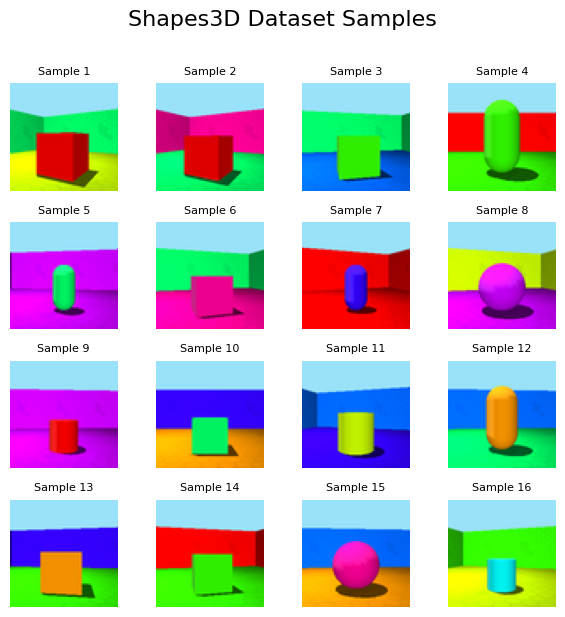

In [8]:
# Visualize some sample data
def show_data_samples(dataset, n_samples=16):
    """Display a grid of sample images from the dataset."""
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    axes = axes.flatten()
    
    # Generate n_samples random indices
    indices = random.sample(range(len(dataset)), n_samples)
    
    for i, idx in enumerate(indices):
        img, factors = dataset[idx]
        
        # Convert from tensor to numpy and transpose for matplotlib
        img_np = img.permute(1, 2, 0).numpy()
        
        axes[i].imshow(img_np)
        axes[i].axis('off')
        axes[i].set_title(f'Sample {i+1}', fontsize=8)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
    fig.suptitle('Shapes3D Dataset Samples', fontsize=16, y=1.02, ha='center')  # Well aligned title
    plt.show()

print("Sample images from the Shapes3D dataset:")
show_data_samples(dataset)

In [11]:
# SN-GAN Configuration
print("Setting up SN-GAN trainer...")

# Model hyperparameters
latent_dim = 10
img_size = (3, 64, 64)  # C, H, W
learning_rate_g = 2e-4
learning_rate_d = 2e-4
beta1 = 0.0  # SN-GAN typically uses beta1=0
beta2 = 0.9

# Create SN-GAN trainer
# The 'sngan' loss type will automatically use spectral normalization in the discriminator
trainer = GANTrainer(
    generator=None,  # Will create default generator
    discriminator=None,  # Will create default discriminator with spectral norm
    loss_type='sngan',  # This uses hinge loss and spectral normalization
    loss_kwargs={},
    g_lr=learning_rate_g,
    d_lr=learning_rate_d,
    beta1=beta1,
    beta2=beta2,
    device=device,
    latent_dim=latent_dim,
    img_size=img_size,
    n_critic=1  # Update generator every discriminator update
)

print(f"SN-GAN trainer created")
print(f"Generator parameters: {sum(p.numel() for p in trainer.generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in trainer.discriminator.parameters()):,}")
print(f"Loss type: {trainer.loss_type}")
print(f"Device: {trainer.device}")

Setting up SN-GAN trainer...
SN-GAN trainer created
Generator parameters: 382,723
Discriminator parameters: 379,073
Loss type: sngan
Device: cuda


In [10]:
# Training Configuration
epochs = 10  # Adjust based on your computational resources
print(f"Starting SN-GAN training for {epochs} epochs...")

# Train the model
trainer.train(dataloader, epochs)

print("Training completed!")

Starting SN-GAN training for 10 epochs...
Starting training for 10 epochs...
Loss type: sngan
Device: cuda


Epoch 0:   0%|                                                                                                                  | 0/7500 [00:00<?, ?it/s]



AttributeError: module 'torch' has no attribute 'leaky_relu'

In [ ]:
# Visualize Training Progress
print("Plotting training losses...")
trainer.plot_losses()

# Show training history summary
if trainer.history['d_loss'] and trainer.history['g_loss']:
    print(f"\nTraining Summary:")
    print(f"Final Discriminator Loss: {trainer.history['d_loss'][-1]:.4f}")
    print(f"Final Generator Loss: {trainer.history['g_loss'][-1]:.4f}")
    print(f"Average Discriminator Loss: {np.mean(trainer.history['d_loss']):.4f}")
    print(f"Average Generator Loss: {np.mean(trainer.history['g_loss']):.4f}")

In [ ]:
# Generate and Display Sample Images
print("Generating sample images from trained SN-GAN...")

# Generate samples using the trained generator
trainer.plot_samples(n_samples=16, n_cols=4, figsize=(10, 10))

# Generate more samples for variety
print("\nGenerating additional samples...")
trainer.plot_samples(n_samples=25, n_cols=5, figsize=(12, 12))

In [ ]:
# Latent Space Exploration
print("Exploring latent space interpolations...")

def interpolate_latent_space(trainer, n_interpolations=8, figsize=(15, 6)):
    """Create interpolations between two random points in latent space."""
    trainer.generator.eval()
    
    with torch.no_grad():
        # Generate two random latent vectors
        z1 = trainer.generate_noise(1)
        z2 = trainer.generate_noise(1)
        
        # Create interpolation weights
        alphas = torch.linspace(0, 1, n_interpolations, device=trainer.device)
        
        interpolated_images = []
        for alpha in alphas:
            # Linear interpolation between z1 and z2
            z_interp = alpha * z2 + (1 - alpha) * z1
            fake_img = trainer.generator(z_interp)
            
            # Denormalize and convert to displayable format
            fake_img = (fake_img + 1) / 2
            fake_img = torch.clamp(fake_img, 0, 1)
            interpolated_images.append(fake_img.cpu())
        
        # Plot interpolations
        fig, axes = plt.subplots(1, n_interpolations, figsize=figsize)
        for i, img in enumerate(interpolated_images):
            img_np = img[0].permute(1, 2, 0).numpy()
            axes[i].imshow(img_np)
            axes[i].axis('off')
            axes[i].set_title(f'α={alphas[i]:.2f}', fontsize=10)
        
        plt.tight_layout()
        plt.suptitle('Latent Space Interpolation', fontsize=14, y=0.98)
        plt.show()
    
    trainer.generator.train()

# Perform several interpolations
for i in range(3):
    print(f"Interpolation {i+1}:")
    interpolate_latent_space(trainer)

In [ ]:
# Save Trained Models and Final Evaluation
import datetime

# Create timestamp for unique filename
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"../../checkpoints/sngan_shapes3d_{timestamp}"
os.makedirs(save_dir, exist_ok=True)

print(f"Saving models to: {save_dir}")

# Save generator and discriminator
torch.save({
    'generator_state_dict': trainer.generator.state_dict(),
    'discriminator_state_dict': trainer.discriminator.state_dict(),
    'g_optimizer_state_dict': trainer.g_optimizer.state_dict(),
    'd_optimizer_state_dict': trainer.d_optimizer.state_dict(),
    'history': trainer.history,
    'config': {
        'latent_dim': latent_dim,
        'img_size': img_size,
        'loss_type': trainer.loss_type,
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rates': {'g_lr': learning_rate_g, 'd_lr': learning_rate_d},
        'betas': {'beta1': beta1, 'beta2': beta2}
    }
}, os.path.join(save_dir, 'sngan_checkpoint.pth'))

# Save loss plots
trainer.plot_losses(save_path=os.path.join(save_dir, 'training_losses.png'))

# Save sample images
trainer.plot_samples(n_samples=25, n_cols=5, figsize=(12, 12), 
                    save_path=os.path.join(save_dir, 'generated_samples.png'))

print("Model and results saved successfully!")
print(f"\nSN-GAN Training Summary:")
print(f"- Dataset: Shapes3D (subset: {dataset.subset*100:.1f}%)")
print(f"- Total images trained on: {len(dataset):,}")
print(f"- Epochs: {epochs}")
print(f"- Batch size: {batch_size}")
print(f"- Latent dimension: {latent_dim}")
print(f"- Loss type: {trainer.loss_type}")
print(f"- Device: {device}")
print(f"- Save directory: {save_dir}")